In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
from datetime import datetime
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date='2017-08-01'
end_date='2017-08-07'

func_results=calc_temps(start_date, end_date)
print(func_results)

[(72.0, 79.25, 83.0)]


[72.0] [79.25] [11.0]


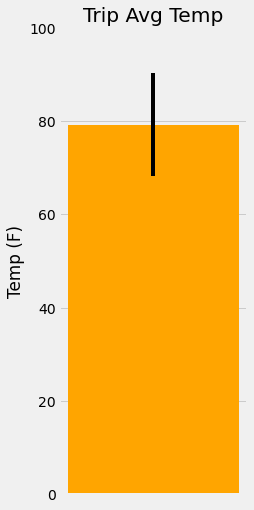

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [func_results[0][0]]
y_pos = [func_results[0][1]]
error = [(func_results[0][2] - func_results[0][0])]
print(x_pos,y_pos,error)

plt.figure(figsize=(3, 8))
plt.bar(x_pos,y_pos,color='orange', yerr=error)

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='-',zorder=1)
plt.savefig('images/Trip Avg Temp.png')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
joined_station=session.query(func.sum(Measurement.prcp).label("total_rainfall"),Station.name,\
                             Station.latitude,Station.longitude,Station.elevation).\
            filter(Station.station == Measurement.station).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            group_by(Measurement.station).order_by(desc("total_rainfall")).statement
df2 = pd.read_sql_query(joined_station, session.bind)

#save the data for the most active station
most_active_station=df2.head(1)

#print the results for all the stations
df2.head(10)

,total_rainfall,name,latitude,longitude,elevation
0,0.36,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,0.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = datetime.strptime('2017-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2017-08-07', '%Y-%m-%d')
normals=[]
trip_dates=[]
# Use the start and end date to create a range of dates
while (start_date<=end_date):
# Strip off the year and save a list of strings in the format %m-%d
    striped = dt.datetime.strftime(start_date,'%m-%d')
    print(start_date)
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
    normals.append(list(np.ravel(daily_normals(striped))))
    trip_dates.append(datetime.strftime(start_date,'%Y-%m-%d'))
    start_date+=dt.timedelta(days = 1)

print(normals)


2017-08-01 00:00:00
2017-08-02 00:00:00
2017-08-03 00:00:00
2017-08-04 00:00:00
2017-08-05 00:00:00
2017-08-06 00:00:00
2017-08-07 00:00:00
[[67.0, 75.54, 83.0], [68.0, 75.60377358490567, 84.0], [70.0, 76.61111111111111, 85.0], [69.0, 76.71153846153847, 84.0], [69.0, 76.14814814814815, 82.0], [67.0, 76.25, 83.0], [71.0, 77.15686274509804, 83.0]]


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
print(daily_normal)
daily_normal['Date'] = trip_dates
daily_normal= daily_normal.set_index("Date")
daily_normal

   tmin       tavg  tmax
0  67.0  75.540000  83.0
1  68.0  75.603774  84.0
2  70.0  76.611111  85.0
3  69.0  76.711538  84.0
4  69.0  76.148148  82.0
5  67.0  76.250000  83.0
6  71.0  77.156863  83.0


,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(-1.0, 0, '2017-08-07'),
  Text(0.0, 0, '2017-08-01'),
  Text(1.0, 0, '2017-08-02'),
  Text(2.0, 0, '2017-08-03'),
  Text(3.0, 0, '2017-08-04'),
  Text(4.0, 0, '2017-08-05'),
  Text(5.0, 0, '2017-08-06'),
  Text(6.0, 0, '2017-08-07'),
  Text(7.0, 0, '')])

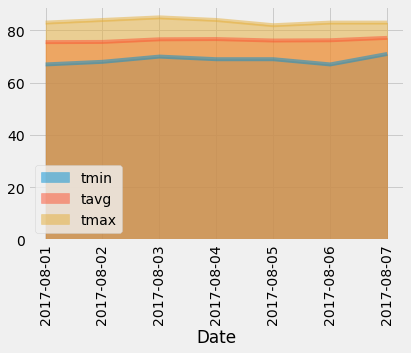

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normal.plot.area(stacked=False)
plt.xticks(rotation=90)

## Close Session

In [27]:
session.close()